**Definition**
(Markov chain/process)

$ (X_i)_{i\in \mathbb{N}} \in S$, where $S$ is finite dimensional and

$P(X_{i} = s_{j_i} | X_{i} = s_{j_{i-1}},X_{i} = s_{j_{i-2}},\dots, X_{i} = s_{j_{0}}) = P(X_{i} = s_{j_i} | X_{i}= s_{j_{i-1}})$ 



In [1]:
# for drawing
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np 
import pyemma   #for hmm and clustering

rng = np.random.default_rng() #define "new" (numpy >=1.19) random number generator

## Sampling from Markov chain

In [2]:
# write small helper class for sampling p is a stochastic matrix i.e. rows sum to 1
class MarkovProcess:
    def __init__(self, p):
        self.p = np.array(p)
    
    def __call__(self,current_state):
        distrb=np.cumsum(self.p[current_state,:])
        r = rng.random()
        return np.where(distrb>r)[0][0]
    

### Too simple rain model

$X_i \in \{0,1\}$
where

|  X  | today |
| --- | ----- |
| 0 | dry   |
| 1 | rain  |


In [3]:
# state 0 is no rain
# state 1 is rain
m = MarkovProcess([[0.8,0.2],
                   [0.3,0.7]])
N=250
data = np.zeros(shape=(N,),dtype=np.int8)
for i in range(N-1):
    data[i+1] = m(data[i])

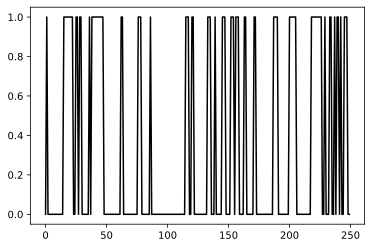

In [4]:
plt.plot(data,"k")

### More *complex* rain model

$X \in \{0,1,2,3\}$
where

|  X  | today | yesterday |
| --- | ----- | --------- |
| 0 | dry  | dry  |
| 1 | dry  | rain |
| 2 | rain | dry  |
| 3 | rain | rain |

**BUT**: There is a hidden physical memory

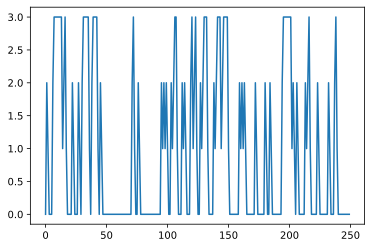

In [5]:
p = [[0.8,0,0.2,0],
     [0.6,0,0.4,0],
     [0,0.5,0,0.5],
     [0,0.3,0,0.7]]
m = MarkovProcess(p)
N=250
data = np.zeros(shape=(N,),dtype=np.int8)
for i in range(N-1):
    data[i+1] = m(data[i])
plt.plot(data)

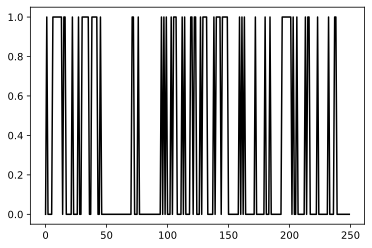

In [6]:
# generate "today is raining" series as in first model
obs = np.zeros_like(data)
obs[np.logical_or(data==2,data==3)]=1
plt.plot(obs,"k")

Observations lead to 
### Hidden Markov state model

In [7]:
def observe(state):
    obs = np.empty(shape=(state.size,))
    mask = state==0
    obs[mask]=rng.normal(0,1,np.count_nonzero(mask))
    mask = state==1
    obs[mask]=rng.normal(2,0.1,np.count_nonzero(mask))
    return obs

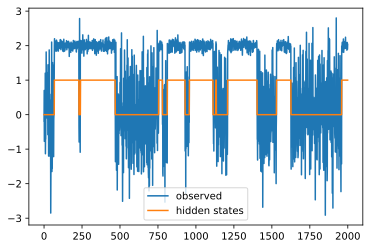

In [8]:
m = MarkovProcess([[0.99,0.01],
                   [0.01,0.99]])
N=20000
data = np.zeros(shape=(N,),dtype=np.int8)
for i in range(N-1):
    data[i+1] = m(data[i])

plt.plot(observe(data[:2000]))
plt.plot(data[:2000])
plt.legend(["observed","hidden states"])

### 2D observations from hidden Markov model

In [9]:
def observe(state):
    mu_0 = [0.0,2.5]
    mu_1 = [1.0,0.0]
    cov_0 = [[1.0,0.5],
             [0.5,1.0]]
    cov_1 = [[1.5,-0.3],
             [-0.3,1.0]] 
    obs = np.empty(shape=(state.size,2))
    mask = state==0
    obs[mask,:]=rng.multivariate_normal(mu_0,cov_0, np.count_nonzero(mask))
    mask = state==1
    obs[mask,:]=rng.multivariate_normal(mu_1,cov_1, np.count_nonzero(mask))
    return obs


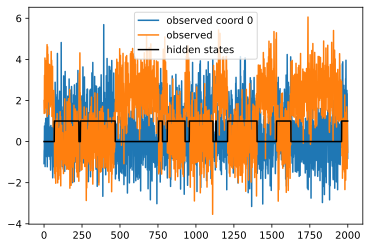

In [10]:
# observe "hidden" Markov state model
obs=observe(data)
plt.plot(obs[:2000])
plt.plot(data[:2000],"k")
plt.legend(["observed coord 0","observed","hidden states"])

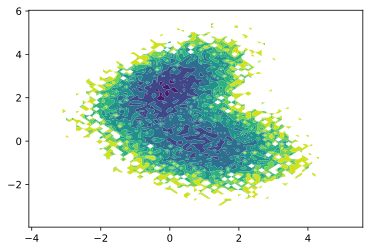

In [11]:
# plot histogram
h, (x,y) = np.histogramdd(obs,bins=100)
plt.contourf(x[:-1], y[:-1], -np.log(h.T))

In [12]:
# cluster for different radii (store results in cls)
cls = [pyemma.coordinates.cluster_regspace(obs, dmin=ii) for ii in [2, 1.5, 1, .5, .25]]

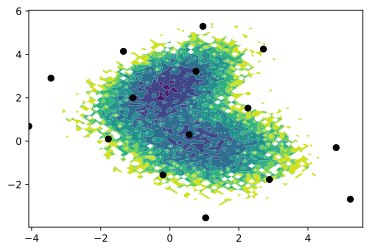

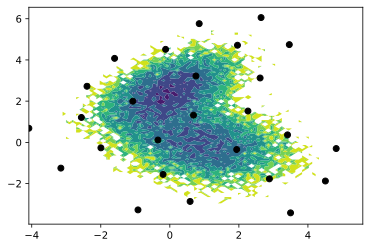

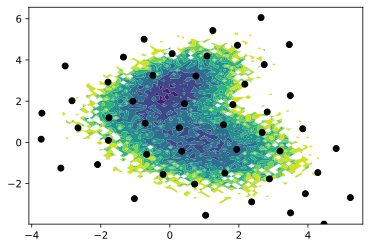

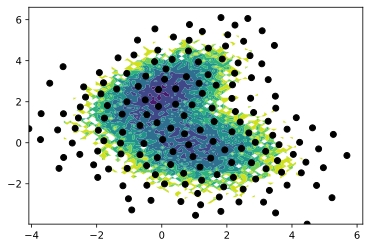

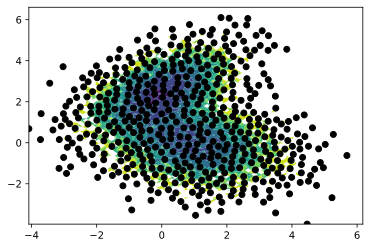

In [13]:
# plot the cluster centers for different radii
for cl in cls:
    plt.figure()
    plt.contourf(x[:-1], y[:-1], -np.log(h.T))
    plt.plot(cl.clustercenters[:,0], cl.clustercenters[:,1],' ok')

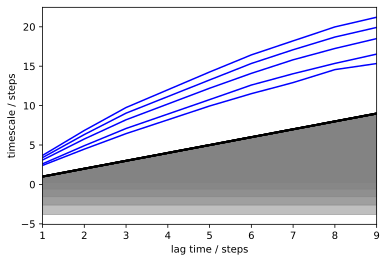

In [14]:
#check if we can directly find Markov state model
its = [pyemma.msm.timescales_msm(cl.dtrajs, lags=[1,2,3,5,6,7,8,9], reversible=True) for cl in cls]
plt.figure()
for iits in its:
    pyemma.plots.plot_implied_timescales(iits, ylog=False, nits=1, ax=plt.gca())

In [15]:
#separation is not too good (due to observation)
icl = cls[-1] # Start with the finer discretization, which was the last one
n_states=2# assume two states
hits = pyemma.msm.timescales_hmsm(icl.dtrajs, n_states, lags=[1,2,3,5,6,7,8,9], reversible=True)


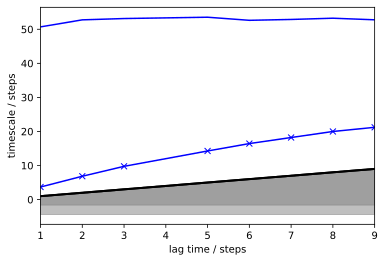

In [16]:
plt.figure()
pyemma.plots.plot_implied_timescales(hits, ylog=False, nits=1, ax=plt.gca(), )
pyemma.plots.plot_implied_timescales(its[-1], ylog=False, nits=1, marker='x', ax=plt.gca())

In [17]:
iHMM = hits.models[0]

In [18]:
# if you want to see the cluster indices which belong to the metastable sets uncomment
#iHMM.metastable_sets

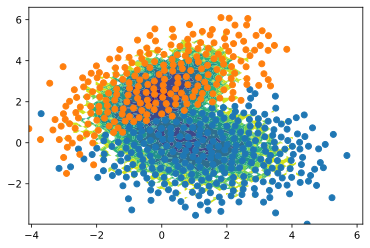

In [19]:
# plot cluster centers in color (depending on which set they belong)
plt.contourf(x[:-1], y[:-1], -np.log(h.T))
for msset in iHMM.metastable_sets:
    plt.plot(cl.clustercenters[msset,0], cl.clustercenters[msset,1],' o')


In [20]:
# read the estimated transition matrix of the hidden markov model
iHMM.transition_matrix

array([[0.99043138, 0.00956862],
       [0.00995779, 0.99004221]])

In [21]:
# the actual transition matrix of hte hidden matrix model
m.p

array([[0.99, 0.01],
       [0.01, 0.99]])